Simulation ended early at t = 17.43 s due to roll angle limit


Animation size has reached 21073491 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


OSError: [Errno 30] Read-only file system: 'bicycle_animation_with_crash.gif'

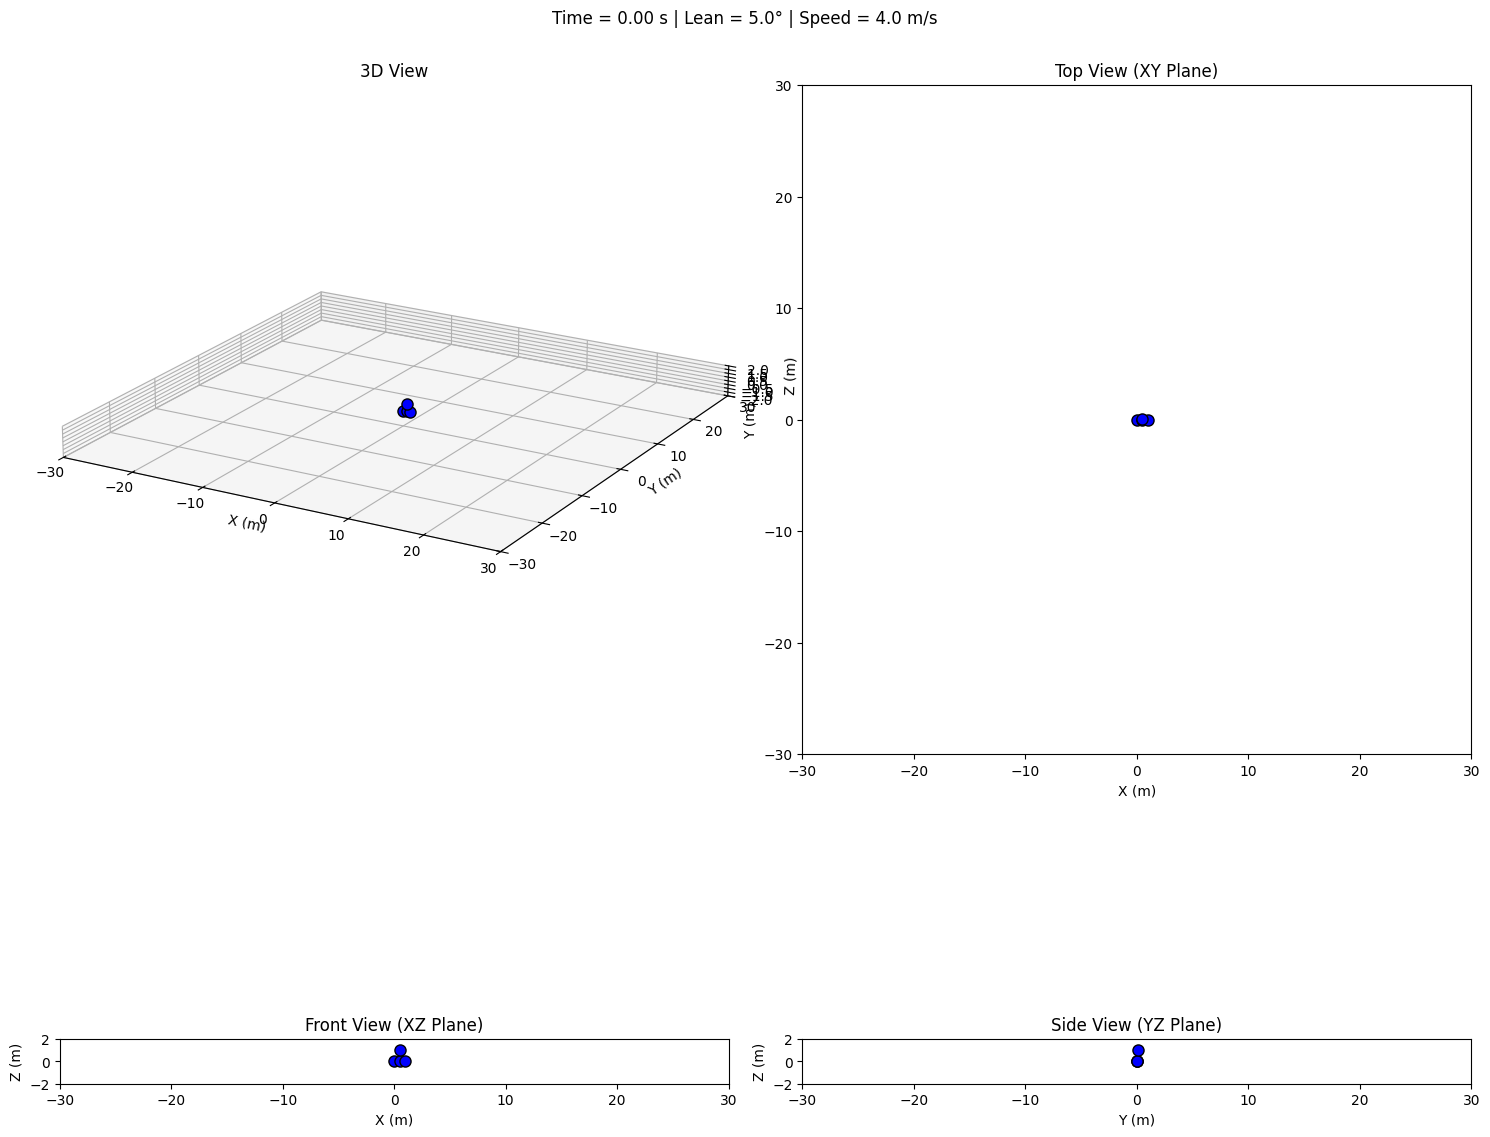

In [1]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Initialize mechanics printing
me.init_vprinting()

# Symbolic parameters
h, a, b, g = sm.symbols('h a b g', real=True)
m, I1, I2, I3 = sm.symbols('m I1 I2 I3', real=True)
CaP, CaR = sm.symbols('CaP CaR', real=True)

# Dynamic symbols
q1, q2, q3, q4, q5 = me.dynamicsymbols('q1 q2 q3 q4 q5')
u1, u2, u3, u4, u5 = me.dynamicsymbols('u1 u2 u3 u4 u5')
t = me.dynamicsymbols._t

# Matrices for states and parameters
q = sm.Matrix([q1, q2, q3, q4])
u = sm.Matrix([u1, u2, u3, u4])
p = sm.Matrix([h, a, b, g, m, I1, I2, I3])
r = sm.Matrix([q5, u5])

# Reference frames and points
N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
C = me.ReferenceFrame('C')

O = me.Point('O')
P = me.Point('P')
Q = me.Point('Q')
R = me.Point('R')
S = me.Point('S')

# Orientation and position setup
A.orient_axis(N, q3, N.z)
B.orient_axis(A, q4, A.x)
C.orient_axis(A, q5, A.z)

P.set_pos(O, q1*N.x + q2*N.y)
Q.set_pos(P, a*A.x)
R.set_pos(P, b*A.x)
S.set_pos(Q, h*B.z)

# Angular velocities
A.set_ang_vel(N, u3*N.z)
B.set_ang_vel(A, u4*A.x)
C.set_ang_vel(A, u5*A.z)

# Velocities
O.set_vel(N, 0)
P.set_vel(N, u1*N.x + u2*N.y)
Q.v2pt_theory(P, N, A)
R.v2pt_theory(P, N, A)
S.v2pt_theory(Q, N, B)

# Inertia and rigid body
IB = me.Inertia.from_inertia_scalars(S, B, I1, I2, I3)
bike_body = me.RigidBody('bike', S, B, m, IB)

# Slip angles
alphaP = sm.atan(P.vel(N).dot(A.y) / P.vel(N).dot(A.x))
alphaR = sm.atan(R.vel(N).dot(C.y) / R.vel(N).dot(C.x))

# Forces
gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

# Kane's method setup
kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t))
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

# Lambdify functions
eval_eom = sm.lambdify((q, u, r, p, CaP, CaR),
                      (kane.mass_matrix_full, kane.forcing_full))
eval_slip = sm.lambdify((q, u, r, p, CaP, CaR), (alphaP, alphaR))

# Control and simulation parameters
target_roll_angle = np.deg2rad(5)
initial_speed = 7.0

# Initialize history lists
control_history = []
control_times = []
alphaP_history = []
alphaR_history = []
time_history = []
FyP_history = []
FyR_history = []

# PD controller
def control(t, q, u):
    gain = 3
    return np.array([gain*(target_roll_angle - q[3]), -gain*u[3]])

# Right-hand side function
def rhs(t, x, p):
    q = x[0:4]
    u = x[4:8]
    
    r = control(t, q, u)
    control_history.append(r)
    control_times.append(t)

    # Update CaP and CaR based on time
    if 15 <= t <= 19.0:
        CaP = 360.0
        CaR = 360.0
    else:
        CaP = 3600.0
        CaR = 3600.0

    M, F = eval_eom(q, u, r, p, CaP, CaR)
    
    alphaP_val, alphaR_val = eval_slip(q, u, r, p, CaP, CaR)
    alphaP_history.append(alphaP_val)
    alphaR_history.append(alphaR_val)

    alpha_max = np.deg2rad(6.0)
    alphaP_val = np.clip(alphaP_val, -alpha_max, alpha_max)
    alphaR_val = np.clip(alphaR_val, -alpha_max, alpha_max)

    time_history.append(t)
    FyP = CaP * alphaP_val
    FyR = CaR * alphaR_val
    FyP_history.append(FyP)
    FyR_history.append(FyR)

    return np.linalg.solve(M, F.squeeze())

# Initial conditions
x0 = np.array([
    0.0,       # q1
    0.0,       # q2
    0.0,       # q3
    np.deg2rad(5.0),  # q4
    4.0,       # u1
    0.0,       # u2
    0.0,       # u3
    0.0        # u4
])

# Parameters
p_vals = np.array([
    1.0,    # h [m]
    0.5,    # a [m]
    1.0,    # b [m]
    9.81,   # g [m/s^2]
    87.0,   # m [kg]
    9.2,    # I1 [kg m^2]
    11.0,   # I2 [kg m^2]
    2.8     # I3 [kg m^2]
])

# Simulation parameters
simulation_time = 30.0
num_frames = 300

# Event function for roll angle
def roll_angle_event(t, x, p):
    roll_angle = np.rad2deg(x[3])
    max_angle = 90
    return roll_angle**2 - max_angle**2

roll_angle_event.terminal = True
roll_angle_event.direction = 0

# Run simulation
solution = solve_ivp(rhs, (0.0, simulation_time), x0, args=(p_vals,),
                    dense_output=True, events=roll_angle_event)

# Determine actual end time
if solution.t_events[0].size > 0:
    actual_end_time = solution.t_events[0][0]
    print(f"Simulation ended early at t = {actual_end_time:.2f} s due to roll angle limit")
else:
    actual_end_time = simulation_time

# Create time array
t_eval = np.linspace(0, actual_end_time, num_frames)
xs = solution.sol(t_eval).T

# Function to evaluate point positions
def eval_point_coords(q, p, steer):
    h_val, a_val, b_val = p[0], p[1], p[2]
    q1, q2, q3, q4 = q
    steer_angle, steer_rate = steer
    
    P_pos = np.array([q1, q2, 0])
    Q_pos = P_pos + a_val * np.array([np.cos(q3), np.sin(q3), 0])
    R_pos = P_pos + b_val * np.array([np.cos(q3), np.sin(q3), 0])
    S_pos = Q_pos + h_val * np.array([
        -np.sin(q4)*np.sin(q3),
        np.sin(q4)*np.cos(q3),
        np.cos(q4)
    ])
    
    return np.vstack([P_pos, Q_pos, R_pos, S_pos]).T

# Prepare coordinates
coords = []
for xi in xs:
    coords.append(eval_point_coords(xi[:4], p_vals, [np.deg2rad(2), 0]))
coords = np.array(coords)

# Create figure
fig = plt.figure(figsize=(15, 15))
ax_3d = fig.add_subplot(2, 2, 1, projection='3d')
ax_top = fig.add_subplot(2, 2, 2)
ax_front = fig.add_subplot(2, 2, 3)
ax_side = fig.add_subplot(2, 2, 4)

# Plot properties
line_prop = {
    'color': 'black',
    'marker': 'o',
    'markerfacecolor': 'blue',
    'markersize': 8,
    'linewidth': 2
}

path_prop = {
    'color': 'red',
    'linewidth': 1,
    'alpha': 0.5
}

# Initialize plot elements
lines_3d, = ax_3d.plot([], [], [], **line_prop)
rear_path_3d, = ax_3d.plot([], [], [], **path_prop)
front_path_3d, = ax_3d.plot([], [], [], **path_prop)

lines_top, = ax_top.plot([], [], **line_prop)
rear_path_top, = ax_top.plot([], [], **path_prop)
front_path_top, = ax_top.plot([], [], **path_prop)

lines_front, = ax_front.plot([], [], **line_prop)
rear_path_front, = ax_front.plot([], [], **path_prop)
front_path_front, = ax_front.plot([], [], **path_prop)

lines_side, = ax_side.plot([], [], **line_prop)
rear_path_side, = ax_side.plot([], [], **path_prop)
front_path_side, = ax_side.plot([], [], **path_prop)

# Axis labels and titles
ax_3d.set_xlabel('X (m)')
ax_3d.set_ylabel('Y (m)')
ax_3d.set_zlabel('Z (m)')
ax_3d.set_title('3D View')
ax_3d.view_init(elev=20, azim=-60)

ax_top.set_xlabel('X (m)')
ax_top.set_ylabel('Y (m)')
ax_top.set_title('Top View (XY Plane)')

ax_front.set_xlabel('X (m)')
ax_front.set_ylabel('Z (m)')
ax_front.set_title('Front View (XZ Plane)')

ax_side.set_xlabel('Y (m)')
ax_side.set_ylabel('Z (m)')
ax_side.set_title('Side View (YZ Plane)')

# Axis limits
x_lim = (-30, 30)
y_lim = (-30, 30)
z_lim = (-2, 2)

ax_3d.set_xlim(x_lim)
ax_3d.set_ylim(y_lim)
ax_3d.set_zlim(z_lim)
ax_3d.set_box_aspect([x_lim[1]-x_lim[0], y_lim[1]-y_lim[0], z_lim[1]-z_lim[0]])

ax_top.set_xlim(x_lim)
ax_top.set_ylim(y_lim)
ax_top.set_aspect('equal')

ax_front.set_xlim(x_lim)
ax_front.set_ylim(z_lim)
ax_front.set_aspect('equal')

ax_side.set_xlim(y_lim)
ax_side.set_ylim(z_lim)
ax_side.set_aspect('equal')

fig.tight_layout()

title_template = 'Time = {:1.2f} s | Lean = {:1.1f}° | Speed = {:1.1f} m/s'
title_text = fig.suptitle('')

# Animation function
def animate(i):
    x = xs[i]
    lean_deg = np.rad2deg(x[3])
    speed = x[4]
    
    if solution.t_events[0].size > 0 and i == len(t_eval)-1:
        title_text.set_text(f"CRASH! {title_template.format(t_eval[i], lean_deg, speed)}")
    else:
        title_text.set_text(title_template.format(t_eval[i], lean_deg, speed))
    
    points = coords[i]
    
    # Update 3D view
    lines_3d.set_data_3d(points[0], points[1], points[2])
    rear_path_3d.set_data_3d(coords[:i+1, 0, 0], coords[:i+1, 1, 0], coords[:i+1, 2, 0])
    front_path_3d.set_data_3d(coords[:i+1, 0, 2], coords[:i+1, 1, 2], coords[:i+1, 2, 2])
    
    # Update 2D views
    lines_top.set_data(points[0], points[1])
    rear_path_top.set_data(coords[:i+1, 0, 0], coords[:i+1, 1, 0])
    front_path_top.set_data(coords[:i+1, 0, 2], coords[:i+1, 1, 2])
    
    lines_front.set_data(points[0], points[2])
    rear_path_front.set_data(coords[:i+1, 0, 0], coords[:i+1, 2, 0])
    front_path_front.set_data(coords[:i+1, 0, 2], coords[:i+1, 2, 2])
    
    lines_side.set_data(points[1], points[2])
    rear_path_side.set_data(coords[:i+1, 1, 0], coords[:i+1, 2, 0])
    front_path_side.set_data(coords[:i+1, 1, 2], coords[:i+1, 2, 2])

# Create animation
fps = 10
ani = FuncAnimation(
    fig, 
    animate, 
    frames=len(t_eval), 
    interval=1000/fps,
    repeat=False
)

# Display and save
HTML(ani.to_jshtml(fps=fps))
ani.save('bicycle_animation_with_crash.gif', writer='pillow', fps=fps, dpi=100)